In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from scipy.signal import find_peaks
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


In [5]:
def integrate_s2(file, s2_lowcut=0.5e-5, s2_upcut=1.5e-5):
    wf = wfm2read(file)
    t, V = wf[1], -wf[0]
    
    bs_lowcut = 2e-5
    bs_upcut = 4e-5
    baseline_window = (t > bs_lowcut) & (t < bs_upcut)
    baseline = np.mean(V[baseline_window])
    V -= baseline

    s2_window = (t > s2_lowcut) & (t < s2_upcut)
    area_s2 = np.trapz(V[s2_window], t[s2_window]) * 1e6 / 1e-3  # Convert to milivolts / microsec
    return area_s2, V, t

def plot_s2_integration(t, V, s2_lowcut, s2_upcut, trig_x = None, trig_y = None):

    plt.plot(t, V, label='SCA Waveform')
    if trig_x is not None and trig_y is not None:
        plt.plot(trig_x, trig_y, label='Trigger SCA', color='orange')

    plt.fill_betweenx(
        [0, 1],
        x1=s2_lowcut,
        x2=s2_upcut,
        color='green',
        alpha=0.3,
        label='S2 window'
    )
    plt.gca().set(xlabel='Time (s)', ylabel='Voltage (V)', title='SCA Waveform with Trigger')

def extract_s2_areas(files):
    areas = []
    for f in files:
        as2, V, t = integrate_s2(f)
        areas.append(as2)
    return np.array(areas)

def apply_hist_cuts(arr, lowcut, upcut):
    return arr[(arr > lowcut) & (arr < upcut)]


In [12]:
trigger_file = r'E:\Pablos_Mighty_measurements\RUN1\GasCirculation_5GSsec_TriggerSCA_EL2100V\sca_waveform.wfm'
trig = wfm2read(trigger_file, verbose=False)
trig_x, trig_y = trig[1], trig[0]
trig_y = trig_y / (10 * np.max(trig_y))

# Define voltage values for scan
voltages = ['2100', '2600', '3100', '3600']

# Build paths and file lists using a loop
base_path = r'E:\Pablos_Mighty_measurements\RUN1\VoltageScan_5GSsec_EL{}\\*.wfm'
voltage_files = {}
for v in voltages:
    path = base_path.format(v)
    files = sorted(glob(path))
    voltage_files[v] = files
    print(f"Voltage {v}V: {len(files)} files")

# For compatibility with previous cells, you can still assign:
files21 = voltage_files['2100']
files26 = voltage_files['2600']
files31 = voltage_files['3100']
files36 = voltage_files['3600']

Voltage 2100V: 3000 files
Voltage 2600V: 3000 files
Voltage 3100V: 3000 files
Voltage 3600V: 3000 files


In [13]:
# Define voltage scan groups and their file lists
voltage_groups = {
    '2100': files21,
    '2600': files26,
    '3100': files31,
    '3600': files36
}

s2_lowcut = 0.5e-5
s2_upcut = 1.5e-5
hist_lowcut = -20
hist_upcut = 20


# Process all voltage groups
s2_areas = {}
s2_areas_cuts = {}
for v, files in voltage_groups.items():
    arr = extract_s2_areas(files)
    s2_areas[v] = arr
    s2_areas_cuts[v] = apply_hist_cuts(arr, hist_lowcut, hist_upcut)

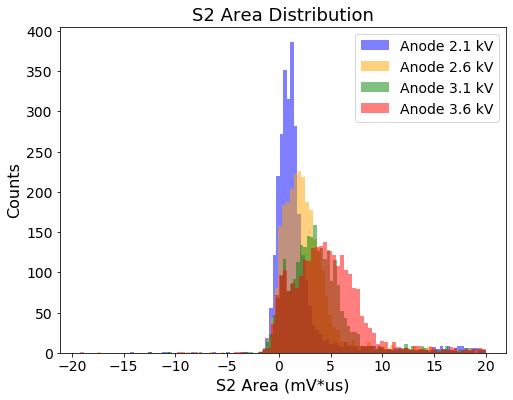

In [14]:
plt.figure(figsize=(8, 6))
for v, label, color in zip(['2100', '2600', '3100', '3600'],
                              ['Anode 2.1 kV', 'Anode 2.6 kV', 'Anode 3.1 kV', 'Anode 3.6 kV'],
                              ['blue', 'orange', 'green', 'red']):
    plt.hist(s2_areas_cuts[v], bins=100, alpha=0.5, label=label, color=color)

plt.gca().set(xlabel='S2 Area (mV*us)', ylabel='Counts', title='S2 Area Distribution')
plt.legend()

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


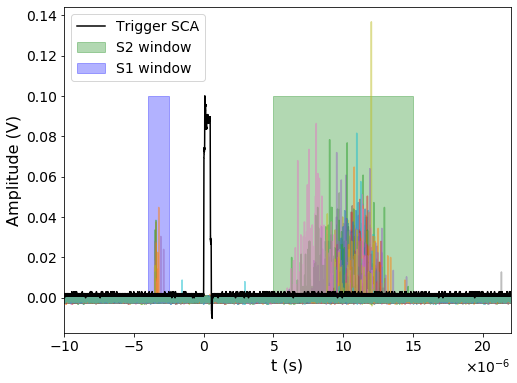

In [11]:
plt.figure(figsize=(8, 6))
for f in files21[:50]:
    wf = wfm2read(f)
    y, t = -wf[0], wf[1]
    plt.plot(t, y, alpha=0.5)

plt.plot(trig_x, trig_y, label='Trigger SCA', color='black')
plt.fill_betweenx(
        [0, 0.1],
        x1=s2_lowcut, x2=s2_upcut,
        color='green', alpha=0.3, label='S2 window'
    )

s1_lowcut = -0.4e-5
s1_upcut = -0.25e-5
plt.fill_betweenx(
        [0, 0.1],
        x1=s1_lowcut, x2=s1_upcut,
        color='blue', alpha=0.3, label='S1 window'
    )


plt.gca().set(xlim=(-1e-5, 2.2e-5), xlabel='t (s)', ylabel='Amplitude (V)')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))